In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, RANSACRegressor

from scipy import stats

import joblib

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date, date2num
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
#ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
metop = 'MetOP_A'
dsA = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_A.nc')
dsB = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_B.nc')
dsB['count'] = dsB['count'] + np.max(dsA['count'].to_numpy()) + 1

ds = xr.concat([dsA, dsB], dim='count')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [3]:
data = ds.to_dataframe()
df = data.copy()

In [4]:
ds

<xarray.Dataset>
Dimensions:                                         (count: 75155)
Coordinates:
  * count                                           (count) int64 0 1 ... 75595
Data variables: (12/57)
    Wind Direction (TAO)                            (count) float32 122.0 ......
    WDIR_QC                                         (count) float32 2.0 ... 1.0
    WDIR_DM                                         (count) |S1 b'D' ... b'D'
    Wind Speed (TAO)                                (count) float32 7.01 ... ...
    WSPD_QC                                         (count) float32 2.0 ... 1.0
    WSPD_DM                                         (count) |S1 b'D' ... b'D'
    ...                                              ...
    Meridional Wind Speed (ASCAT)                   (count) float64 4.831 ......
    Direction Difference (ASCAT - TAO)              (count) float64 14.9 ... ...
    cos(Direction Difference (ASCAT - TAO))         (count) float64 0.9664 .....
    sin(Direction Difference (ASCAT - TAO))         (count) float64 0.2571 .....
    Zonal Wind Speed Difference (ASCAT - TAO)       (count) float64 -1.105 .....
    Meridional Wind Speed Difference (ASCAT - TAO)  (count) float64 -1.663 .....

In [5]:
selectX = ['Speed Difference (ASCAT - TAO)',
          'cos(Direction Difference (ASCAT - TAO))',
          'sin(Direction Difference (ASCAT - TAO))']

X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

#dbscan = DBSCAN(eps=0.15, min_samples= 500) ## for QuikSCAT
dbscan = DBSCAN(eps=0.21, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

In [6]:
# load trained model 
classifier = joblib.load("../../classification_machineLearning/randomForest/random_forest_rainDetection.joblib")

In [24]:
# Features used for classification
features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']
mask = np.isnan(df[features[0]])

for ftr in features:
    mask += np.isnan(df[ftr])

df = df.loc[~mask]

mask = np.isnan(df[features[0]])

for ftr in features:
    mask += np.isnan(df[ftr])

In [25]:
np.sum(mask)

0

In [26]:
X = df[features]

#predict rain flags
y_pred = classifier.predict(X)
df['predicted_rain_flag'] = y_pred

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='predicted_rain_flag', ylabel='count'>

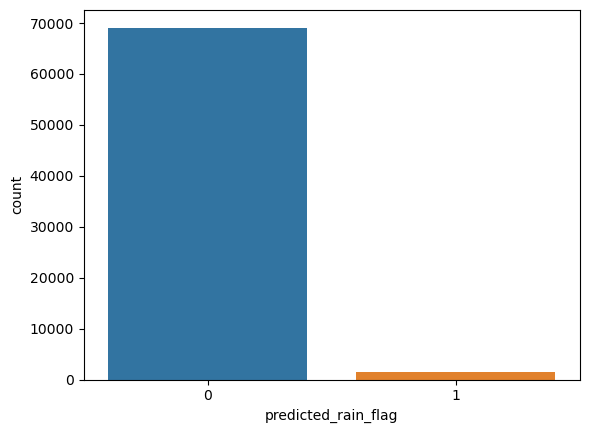

In [28]:
sns.countplot(df, x='predicted_rain_flag')

In [30]:
def plotSusanLikeWithoutCorrectedAngle(SUBDF, lat, lon, suffix='all'):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return
    
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
        
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['AS_TIME']))
        endDates.append(np.max(ssubDF['AS_TIME']))
        
        x = ((np.array(ssubDF['AS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m'))
    
        y = np.array(ssubDF['ratio'])

        mask = np.logical_or(np.isnan(y), abs(y) > 100)
        x = x[~mask].reshape(-1,1)
        y = y[~mask].reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        
        axes[0].plot(ssubDF['AS_TIME'][~mask], Y, color='k')
    
        x = ((np.array(ssubDF['AS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m'))
    
        y = np.array(ssubDF['angle_diff'])

        mask = np.logical_or(np.isnan(y), abs(y) > 100)
        x = x[~mask].reshape(-1,1)
        y = y[~mask].reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        
        axes[1].plot(ssubDF['AS_TIME'][~mask], Y, color='k')
        
    ax = axes[0]
    ax.scatter(subDF['AS_TIME'], ratio, c = 'r', s = 0.2)
    
    ax = axes[1]
    ax.scatter(subDF['AS_TIME'], angle, c = 'r', s = 0.2)
    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (AS/TAO)')
    axes[1].set_title('Difference in wind direction (AS - TAO)')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    
    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    title = f'images/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_{suffix}.png'
    plt.savefig(title, dpi = 100)
    plt.close()

In [35]:
def plotSusanLikeWithCorrectedAngle(SUBDF, lat, lon, suffix='all'):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return
    
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,12))
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['AS_TIME']))
        endDates.append(np.max(ssubDF['AS_TIME']))
        
        x = ((np.array(ssubDF['AS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['AS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['AS_TIME'], Y, color='k')
        
        y -= Y #(Y - np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['AS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (ASCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['AS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    
    ax = axes[1]
    ax.scatter(subDF['AS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)

    ax = axes[2]
    ax.scatter(subDF['AS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (AS/TAO)')
    axes[1].set_title('Difference in wind direction (AS - TAO)')
    axes[2].set_title('Difference in wind direction (AS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')
    
    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    title = f'images/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_{suffix}.png'
    plt.savefig(title, dpi = 100)
    plt.close()

In [36]:
def plotSusanLikeWithCorrectedAngleGreyBad(SUBDF, lat, lon, suffix='all'):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return
    
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]


    subDF2 = subDF.loc[subDF['label'] == -1]
    subDF = subDF.loc[subDF['label'] == 0]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,12))
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['AS_TIME']))
        endDates.append(np.max(ssubDF['AS_TIME']))
        
        x = ((np.array(ssubDF['AS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['AS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['AS_TIME'], Y, color='k')
        
        y -= Y #- np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['AS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (ASCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['AS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    ax.scatter(subDF2['AS_TIME'], subDF2['ratio'], c = 'grey', s = 0.4)
    
    ax = axes[1]
    ax.scatter(subDF['AS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)
    ax.scatter(subDF2['AS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    ax = axes[2]
    ax.scatter(subDF['AS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)
    #ax.scatter(subDF2['AS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[2].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (AS/TAO)')
    axes[1].set_title('Difference in wind direction (AS - TAO)')
    axes[2].set_title('Difference in wind direction (AS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')
    
    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    title = f'images/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_{suffix}.png'
    plt.savefig(title, dpi = 100)
    plt.close()

In [37]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

In [38]:
subDF = df.loc[df['predicted_rain_flag'] == 0]
subDF = subDF.loc[subDF['label'] == 0]
# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithoutCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithoutCorrection')

# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithAngleCorrection')

for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    plotSusanLikeWithCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithAngleCorrection')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
# subDF = df.loc[df['predicted_rain_flag'] == 0]
# subDF = subDF.loc[subDF['label'] == 0]
# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithoutCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithoutCorrection')

# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithAngleCorrection')

for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    plotSusanLikeWithCorrectedAngleGreyBad(df, lat, lon, suffix='goodRedBadGrey')